## _Response Modeling of Bank Marketing Campaign_

<br />

<img src="AI.png" width = '400'><br>


### _Business Scenario_

There has been a revenue decline for the Portuguese bank and they would like to know what actions to take. After investigation, we found out that the root cause is that their clients are not depositing as frequently as before. Knowing that term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can invest in higher gain financial products to make a profit. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues. As a result, the Portuguese bank would like to identify existing clients that have higher chance to subscribe for a term deposit and focus marketing effort on such clients.


* The task is to build a POC for the problem

* The data is related with direct marketing campaigns of a Portuguese banking institution. 

* The marketing campaigns were based on phone calls. 

* Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

## _Attributes Information_


### _Bank client data:_
1 - age (numeric)

2 - job : type of job 
(categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status 
(categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### _Data Related to the last contact of the current campaign:_
8 - contact: contact communication type (categorical: 'cellular','telephone') 

9 - month: last contact month of year 
(categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week 
(categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). 
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### _Other attributes:_

12 - campaign: number of contacts performed during this campaign and for this client 
(numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign 
(numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### _Social and economic context attributes_
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric) 

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## _Exploratory Analysis_

### _Import Libraries_

In [1]:
# !pip install imblearn
#if the above command does not work to install imblearn package, run the following command in your terminal

# !conda install -c glemaitre imbalanced-learn

In [2]:
# !pip install seaborn

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score


Using TensorFlow backend.


In [5]:
# Define custom function to print accuracy, precision and recall

def convert_for_sklearn(label_list):
    return [1 if i == 'yes' else 0 for i in label_list]


def accuracy_precision_recall_metrics(y_true, y_pred):
    
    y_test_scoring = convert_for_sklearn(y_true)
    test_pred_scoring = convert_for_sklearn(y_pred)

    acc = accuracy_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    prec = precision_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    rec = recall_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    
    print("Test Precision: ",prec)
    print("Test Recall: ",rec)
    print("Test Accuracy: ",acc)

### _Read in the data_

In [6]:
bank_data = pd.read_csv("bank-additional-full.csv", na_values='unknown')
test_data =  pd.read_csv("test_cases.csv", na_values='unknown')

print(bank_data.shape)
print(test_data.shape)

bank_data.head()

(41188, 22)
(4119, 22)


,customer_no,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2,57,services,married,high.school,NaN,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,3,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,4,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,5,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### _Understand the dataset_

In [7]:
# What are the data types?
bank_data.dtypes

customer_no          int64
age                  int64
job                 object
marital             object
education           object
credit_default      object
housing             object
loan                object
contact             object
contacted_month     object
day_of_week         object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome            object
emp_var_rate       float64
cons_price_idx     float64
cons_conf_idx      float64
euribor3m          float64
nr_employed        float64
y                   object
dtype: object

In [8]:
# What is the distribution of numerical columns?
bank_data.describe()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,11890.09578,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,1.00000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,10297.75000,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,20594.50000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,30891.25000,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,41188.00000,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [9]:
# What about categorical variable levels count?
bank_data.describe(include=['object'])

,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [10]:
bank_data.marital.value_counts()

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64

### _Distribution of dependent variable_

In [11]:
bank_data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [12]:
# Check the distribution of target values
bank_data.y.value_counts(normalize=True)*100

no     88.734583
yes    11.265417
Name: y, dtype: float64

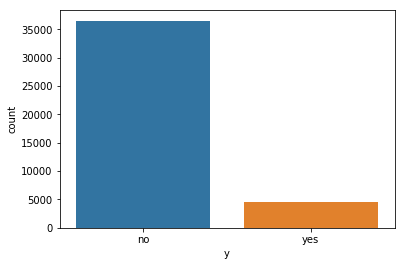

no     36548
yes     4640
Name: y, dtype: int64
Percentage of people who have taken the campaign: 11.265417111780131 %


In [13]:
# Plot Distribution
sns.countplot(x='y',data=bank_data)
plt.show()

# What are the counts?
print(bank_data.y.value_counts())

# What is the percentage?
count_yes = len(bank_data[bank_data.y == 'yes'])
count_no = len(bank_data[bank_data.y != 'yes'])

percent_success = (count_yes/(count_yes + count_no))*100

print('Percentage of people who have taken the campaign:', percent_success, "%")

### _Distribution of Other Variables_

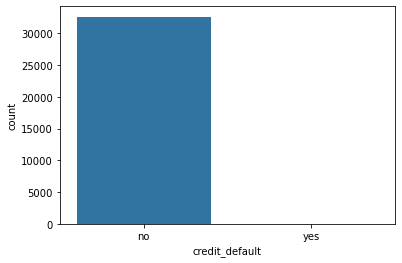

no     32588
yes        3
Name: credit_default, dtype: int64

In [14]:
sns.countplot(x="credit_default", data=bank_data)
plt.show()

bank_data.credit_default.value_counts()

In [26]:
## when someone is subscribing for the campaign, is it on a particular day of the week?
bank_data[bank_data.y == 'yes'].day_of_week.value_counts(normalize=True)*100

thu    22.521552
tue    20.538793
wed    20.452586
mon    18.254310
fri    18.232759
Name: day_of_week, dtype: float64

In [27]:
bank_data[bank_data.y == 'yes'].marital.value_counts(normalize=True)*100

married     54.710458
single      35.004322
divorced    10.285220
Name: marital, dtype: float64

In [15]:
bank_data.marital.value_counts(normalize=True)*100

married     60.640265
single      28.140508
divorced    11.219227
Name: marital, dtype: float64

### _Drawing trends toward the target variable_

In [17]:
bank_data.groupby('y').mean()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,,
no,19354.359719,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,30362.742888,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


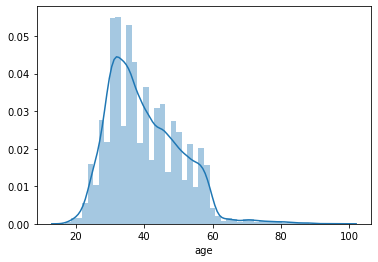

In [18]:
# Check distribution of age
%matplotlib inline
sns.distplot(bank_data["age"] )

In [19]:
# Does the kind of job matter to a subscription? (groupby job and aggregate by mean) 
# Extend to education, marital, etc.

bank_data.groupby('job').mean()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
job,,,,,,,,,,,
admin.,21889.241604,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350
blue-collar,17944.856819,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150
entrepreneur,19220.407280,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530
housemaid,18643.689623,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623
management,21014.031806,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513
retired,26087.565698,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151
self-employed,20724.339198,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384
services,18931.184681,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126
student,30845.699429,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086


In [20]:
# Who are subscribing the most across job ranks?
bank_data[bank_data.y == 'yes'].job.value_counts(normalize=True)*100

admin.           29.372149
technician       15.859222
blue-collar      13.860526
retired           9.428633
management        7.125788
services          7.017163
student           5.974365
self-employed     3.237019
unemployed        3.128395
entrepreneur      2.693895
housemaid         2.302846
Name: job, dtype: float64

In [21]:
# Who are subscribing the most across job ranks?
bank_data.job.value_counts(normalize=True)*100

admin.           25.507856
blue-collar      22.649175
technician       16.503500
services          9.714132
management        7.156493
retired           4.209702
entrepreneur      3.563562
self-employed     3.477899
housemaid         2.594351
unemployed        2.481766
student           2.141563
Name: job, dtype: float64

### _Some Insights from the EDA done above_

* Number of Campaigns are lower for people who subscribed!

* People who subscribed for a term deposit are older (average age)

* customer_no attribute looks to be providing no value. Hence can be removed

* Few attributes such as job, marital, education, credit_default, housing, loan, contact, contacted_month, day_of_week, poutcome and y are categorical but are interpreted as object type. 

### _Feature Engineering_

#### _Fix levels of categorical variable by domain_

In [22]:
# Check levels of education. Is there anything wrong?
print(bank_data.education.value_counts())

# clean up basic level 
bank_data.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)
test_data.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64


In [23]:
bank_data.education.value_counts()

basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
illiterate                18
Name: education, dtype: int64

In [34]:
test_data.education.value_counts()

university.degree      1246
basic                  1239
high.school             948
professional.course     521
illiterate                1
Name: education, dtype: int64

#### _Drop unnecessary variables_ from both bank_data and test_data

In [24]:
bank_data.drop("customer_no", axis = 1, inplace= True)
test_data.drop("customer_no", axis = 1, inplace= True)

bank_data.head()

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [25]:
print(bank_data.shape)
print(test_data.shape)

(41188, 21)
(4119, 21)


In [26]:
bank_data.dtypes

age                  int64
job                 object
marital             object
education           object
credit_default      object
housing             object
loan                object
contact             object
contacted_month     object
day_of_week         object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome            object
emp_var_rate       float64
cons_price_idx     float64
cons_conf_idx      float64
euribor3m          float64
nr_employed        float64
y                   object
dtype: object

#### _Type Casting_

In [27]:
col = ['job', 'marital', 'education', 'credit_default', 'housing', 'loan', 'contact', 'contacted_month', 'day_of_week', 'poutcome', 'y']
bank_data[col] = bank_data[col].astype('category')



In [28]:
bank_data.dtypes

age                   int64
job                category
marital            category
education          category
credit_default     category
housing            category
loan               category
contact            category
contacted_month    category
day_of_week        category
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome           category
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                  category
dtype: object

> How to choose between category and object:

reference : https://stackoverflow.com/questions/30601830/when-to-use-category-rather-than-object

The categorical data type is useful in the following cases:

* A string variable consisting of only a few different values. Converting such a string variable to a categorical variable will save some memory
* The lexical order of a variable is not the same as the logical order (“one”, “two”, “three”). By converting to a categorical and specifying an order on the categories, sorting and min/max will use the logical order instead of the lexical order
* As a signal to other Python libraries that this column should be treated as a categorical variable (e.g. to use suitable statistical methods or plot types).

In [38]:
bank_data.dtypes

age                   int64
job                category
marital            category
education          category
credit_default     category
housing            category
loan               category
contact            category
contacted_month    category
day_of_week        category
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome           category
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                  category
dtype: object

#### Split Numeric and Categorical Columns

In [31]:
cat_attr = list(bank_data.select_dtypes("category").columns)
num_attr = list(bank_data.columns.difference(cat_attr))
cat_attr
cat_attr.pop()

'y'

In [32]:
cat_attr

['job',
 'marital',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'contacted_month',
 'day_of_week',
 'poutcome']

In [33]:
num_attr

['age',
 'campaign',
 'cons_conf_idx',
 'cons_price_idx',
 'duration',
 'emp_var_rate',
 'euribor3m',
 'nr_employed',
 'pdays',
 'previous']

#### _Handle Missing Values_

In [34]:
bank_data.isnull().sum()

age                   0
job                 330
marital              80
education          1731
credit_default     8597
housing             990
loan                990
contact               0
contacted_month       0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
y                     0
dtype: int64

In [35]:
# print total number of missing values
bank_data.isnull().sum().sum()

12718

## Sklearn pipelines

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.

Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. Super convenient, right?

Steps to follow to create a pipeline:

Step 1) Fetch the numerical and categorical columns

Step 2) Create a transformer/pipeline for numerical attributes

    Create a list of tuples where each tuple represents the operation to be performed on numerical attributes

Step 3) Create a transformer/pipeline for categorical attributes

    Create a list of tuples where each tuple represent the operation to be performed on categorical attributes

Step 4) Create a ColumnTransformer which merges both the numerical and categorical transformers

Step 5) Create a final pipeline object which includes the ColumnTransformer and an estimator (an algorithm to be build on dataset)

Step 6) (optional) Create a GridSearchCV object with pipeline as one of the inputs along with hyperparameter grid and Cross validation object

Step 7) Apply fit() on train data and predict() on test data <br><br>

**TL; DR**
Pipeline is a collection of transformers chained together and operate sequentially. (often ending with an estimator)

__Bird's view of sklearn pipeline__

<img src="Pipeline_broadview.png"><br><br>

__Train and Test dataflow inside the sklearn pipeline__
<img src="fit_tranform.jpg">

#### _Instantiate Pre-processing Objects for Pipeline_

In [36]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [37]:
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [38]:
type(numeric_transformer)

sklearn.pipeline.Pipeline

In [39]:
numeric_transformer.named_steps

{'imputer': SimpleImputer(strategy='median'), 'scaler': StandardScaler()}

In [48]:
numeric_transformer.named_steps.scaler

StandardScaler()

In [49]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [50]:
categorical_transformer.named_steps

{'imputer': SimpleImputer(strategy='most_frequent'),
 'onehot': OneHotEncoder(handle_unknown='ignore')}

In [51]:
categorical_transformer.named_steps.imputer

SimpleImputer(strategy='most_frequent')

In [52]:
categorical_transformer.named_steps.onehot

OneHotEncoder(handle_unknown='ignore')

In [53]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'campaign', 'cons_conf_idx',
                                  'cons_price_idx', 'duration', 'emp_var_rate',
                                  'euribor3m', 'nr_employed', 'pdays',
                                  'previous']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education',
                                  'credit_default', '

In [54]:
type(preprocessor)

sklearn.compose._column_transformer.ColumnTransformer

In [55]:
preprocessor.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())]),
   ['age',
    'campaign',
    'cons_conf_idx',
    'cons_price_idx',
    'duration',
    'emp_var_rate',
    'euribor3m',
    'nr_employed',
    'pdays',
    'previous']),
  ('cat',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
   ['job',
    'marital',
    'education',
    'credit_default',
    'housing',
    'loan',
    'contact',
    'contacted_month',
    'day_of_week',
    'poutcome'])],
 'verbose': False,
 'num': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler())]),
 'cat': Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('onehot', OneHotEncoder(handle

#### _Instantiate Pipeline Object_

In [45]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

### _Train-Test Split_

In [46]:
X_train, y_train = bank_data.loc[:,bank_data.columns!='y'], bank_data.loc[:,'y']

X_test, y_test = test_data.loc[:,test_data.columns!='y'], test_data.loc[:,'y']

In [47]:
X_train.head()

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


### _Build Logistic Regression Model - 1_

In [48]:
clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign',
                                                   'cons_conf_idx',
                                                   'cons_price_idx', 'duration',
                                                   'emp_var_rate', 'euribor3m',
                                                   'nr_employed', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('i

### _Evaluate Model_

In [49]:
train_pred = clf_logreg.predict(X_train)
test_pred = clf_logreg.predict(X_test)

print(clf_logreg.score(X_train, y_train))
print(clf_logreg.score(X_test, y_test))
print("\n")
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
confusion_matrix_test

0.9113091191609206
0.9099295945617868


[[35567   981]
 [ 2672  1968]]


array([[3560,   97],
       [ 274,  188]])

In [50]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Test Accuracy: ",Accuracy_test)

Test Precision:  0.6596491228070176
Test Recall:  0.4069264069264069
Test Accuracy:  0.9099295945617868


#### Using the function to calculate accuracy, precision and recall.

In [51]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.6596491228070176
Test Recall:  0.4069264069264069
Test Accuracy:  0.9099295945617868


### _Build Decision Tree Model - 2_

In [53]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5, verbose=50, n_jobs=-1)

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  9.2min
[Paralle

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [61]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 10}

In [54]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))

0.9180586578615131
0.9210973537266327


In [63]:
# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.7120743034055728
Test Recall:  0.49783549783549785
Test Accuracy:  0.9210973537266327


### _Build Random Forest Model - 3_ (Using Stratified KFold)

__Stratified K-Folds cross-validator__

This cross-validation object is a **variation** of KFold that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

In [64]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [76]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid= param_grid, cv=kfold)

In [77]:
rf_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [78]:
%%time
rf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] classifier__min_samples_leaf=10, classifier__n_estimators=150 ...
[CV]  classifier__min_samples_leaf=10, classifier__n_estimators=150, score=0.887, total=   4.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[CV] classifier__min_samples_leaf=10, classifier__n_estimators=150 ...
[CV]  classifier__min_samples_leaf=10, classifier__n_estimators=150, score=0.341, total=   5.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[CV] classifier__min_samples_leaf=10, classifier__n_estimators=150 ...
[CV]  classifier__min_samples_leaf=10, classifier__n_estimators=150, score=0.152, total=   5.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s remaining:    0.0s
[CV] classifier__min_samples_leaf=10, classifier__n_estimators=250 ...
[CV]  classifier__min_samples_leaf=10, classifie

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'cons_conf_idx',
                                                                          'cons_price_idx',
                                                          

In [79]:
rf_grid.best_params_

{'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 250}

In [80]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.9331358648149947
0.9317795581451809
Test Precision:  0.8290909090909091
Test Recall:  0.4935064935064935
Test Accuracy:  0.9317795581451809


### _Build Gradient Boosting - 4_

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier())])

In [ ]:
%%time
gbm_param_grid = {'GBM__max_depth': [8,10,12,14], 'GBM__subsample': [0.8, 0.6,], 'GBM__max_features':[0.2, 0.3], 
              'GBM__n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=3)

gbm_grid.fit(X_train,y_train)

In [ ]:
gbm_grid.best_params_

In [ ]:
train_pred = gbm_grid.predict(X_train)
test_pred = gbm_grid.predict(X_test)

print(gbm_grid.score(X_train, y_train))
print(gbm_grid.score(X_test, y_test))

# Using the function to calcula`te accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

### Build SVM - 5

In [52]:
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

svm_param_grid = {'classifier__C': [50,90], 'classifier__gamma': [0.008, 0.001],
                 "classifier__kernel": ['rbf']}

svm_grid = GridSearchCV(clf_svm, param_grid= svm_param_grid, cv= 5)

svm_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [53]:
svm_grid.best_params_

{'classifier__C': 50, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}

In [54]:
train_pred = svm_grid.predict(X_train)
test_pred = svm_grid.predict(X_test)

print(svm_grid.score(X_train, y_train))
print(svm_grid.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)

0.9097067106924347
0.9082301529497451
[[35854   694]
 [ 3025  1615]]


In [55]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

Test Precision:  0.6909090909090909
Test Recall:  0.329004329004329
Train Accuracy:  0.9082301529497451


## _Handling Imbalanced Data_

### _1. Class Weights of loss function_

In [56]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10],
                 "classifier__class_weight":['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)
dt_grid_bal.fit(X_train,y_train)

CPU times: user 19min 37s, sys: 8.78 s, total: 19min 46s
Wall time: 12min 15s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [57]:
train_pred = dt_grid_bal.predict(X_train)
test_pred = dt_grid_bal.predict(X_test)

print(dt_grid_bal.score(X_train, y_train))
print(dt_grid_bal.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
# accuracy_precision_recall_metrics(y_true = y_train, y_pred= train_pred)
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.8636010488491793
0.8693857732459335
Test Precision:  0.46
Test Recall:  0.9458874458874459
Test Accuracy:  0.8693857732459335


### _2. Oversample Using SMOTE_

<img src="SMOTE.jpg" width = '400'><br>

In [58]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_pp = pd.DataFrame(clf.fit_transform(X_train))
X_test_pp = pd.DataFrame(clf.transform(X_test))

In [59]:
smote = SMOTE(random_state=0)

os_data_X,os_data_y=smote.fit_sample(X_train_pp, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']=='no']))
print("Number of subscription",len(os_data_y[os_data_y['y']=='yes']))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='no'])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='yes'])/len(os_data_X))

length of oversampled data is  73096
Number of no subscription in oversampled data 36548
Number of subscription 36548
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [60]:
%%time
clf_dt = Pipeline(steps=[('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid_bal.fit(os_data_X,os_data_y)

CPU times: user 3min 28s, sys: 44.4 ms, total: 3min 28s
Wall time: 3min 28s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        DecisionTreeClassifier(class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
   

In [61]:
train_pred = dt_grid_bal.predict(os_data_X).reshape(1,-1)[0]
test_pred = dt_grid_bal.predict(X_test_pp).reshape(1,-1)[0]

print(dt_grid_bal.score(os_data_X, os_data_y))
print(dt_grid_bal.score(X_test_pp, y_test))

0.9161924045091386
0.8858946346200534


In [62]:
confusion_matrix_train = confusion_matrix(y_true=os_data_y, y_pred = train_pred)
confusion_matrix_train

array([[32360,  4188],
       [ 1938, 34610]])

In [63]:
Accuracy_train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(np.sum(confusion_matrix_train))

Precision_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,1]+confusion_matrix_train[0,1])
Recall_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train Precision: ",Precision_Train)
print("Train Recall: ",Recall_Train)
print("Train Accuracy: ",Accuracy_train)

Train Precision:  0.8920562915614207
Train Recall:  0.9469738426179272
Train Accuracy:  0.9161924045091386


In [64]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.4951338199513382
Test Recall:  0.8809523809523809
Test Accuracy:  0.8858946346200534


# Random Forest with important features.

In [65]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [66]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid=param_grid, cv=kfold)

In [67]:
%%time
rf_grid.fit(X_train,y_train)

CPU times: user 58min 21s, sys: 15.3 s, total: 58min 36s
Wall time: 47min 59s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [68]:
rf_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 4,
 'classifier__n_estimators': 150}

In [69]:
pl = rf_grid.best_estimator_.named_steps['preprocessor']
catpl = pl.named_transformers_['cat']
ohe = catpl.named_steps['onehot']
ohe_features = ohe.get_feature_names()
print(ohe_features)

['x0_admin.' 'x0_blue-collar' 'x0_entrepreneur' 'x0_housemaid'
 'x0_management' 'x0_retired' 'x0_self-employed' 'x0_services'
 'x0_student' 'x0_technician' 'x0_unemployed' 'x1_divorced' 'x1_married'
 'x1_single' 'x2_basic' 'x2_high.school' 'x2_illiterate'
 'x2_professional.course' 'x2_university.degree' 'x3_no' 'x3_yes' 'x4_no'
 'x4_yes' 'x5_no' 'x5_yes' 'x6_cellular' 'x6_telephone' 'x7_apr' 'x7_aug'
 'x7_dec' 'x7_jul' 'x7_jun' 'x7_mar' 'x7_may' 'x7_nov' 'x7_oct' 'x7_sep'
 'x8_fri' 'x8_mon' 'x8_thu' 'x8_tue' 'x8_wed' 'x9_failure'
 'x9_nonexistent' 'x9_success']


In [70]:
num_attr.extend(ohe_features)
num_attr

['age',
 'campaign',
 'cons_conf_idx',
 'cons_price_idx',
 'duration',
 'emp_var_rate',
 'euribor3m',
 'nr_employed',
 'pdays',
 'previous',
 'x0_admin.',
 'x0_blue-collar',
 'x0_entrepreneur',
 'x0_housemaid',
 'x0_management',
 'x0_retired',
 'x0_self-employed',
 'x0_services',
 'x0_student',
 'x0_technician',
 'x0_unemployed',
 'x1_divorced',
 'x1_married',
 'x1_single',
 'x2_basic',
 'x2_high.school',
 'x2_illiterate',
 'x2_professional.course',
 'x2_university.degree',
 'x3_no',
 'x3_yes',
 'x4_no',
 'x4_yes',
 'x5_no',
 'x5_yes',
 'x6_cellular',
 'x6_telephone',
 'x7_apr',
 'x7_aug',
 'x7_dec',
 'x7_jul',
 'x7_jun',
 'x7_mar',
 'x7_may',
 'x7_nov',
 'x7_oct',
 'x7_sep',
 'x8_fri',
 'x8_mon',
 'x8_thu',
 'x8_tue',
 'x8_wed',
 'x9_failure',
 'x9_nonexistent',
 'x9_success']

In [71]:
feature_imp = rf_grid.best_estimator_.steps[1][1].feature_importances_
print(feature_imp)

[2.75403730e-02 9.14164991e-03 4.60364974e-02 3.80716828e-02
 3.40835838e-01 3.82213192e-02 1.03045670e-01 1.23324277e-01
 7.00635692e-02 1.32800180e-02 2.66154232e-03 2.35413449e-03
 5.77510262e-04 4.89567420e-04 1.13954967e-03 3.39204026e-03
 8.22449949e-04 9.48910025e-04 2.05288428e-03 2.10676398e-03
 6.54866477e-04 1.40299492e-03 2.57536737e-03 2.64659922e-03
 2.68069008e-03 2.22584120e-03 9.09908283e-06 1.99454622e-03
 3.65123777e-03 0.00000000e+00 0.00000000e+00 2.77804455e-03
 2.66370715e-03 1.66938411e-03 1.61761603e-03 8.67280100e-03
 1.01763741e-02 5.25635534e-03 1.35224473e-03 9.38121202e-04
 1.49548748e-03 2.78498822e-03 9.76627962e-03 6.85169218e-03
 1.36667285e-03 8.91430285e-03 2.46925131e-03 2.69185977e-03
 4.44761564e-03 3.00981223e-03 2.67043704e-03 2.42417880e-03
 8.14641939e-03 9.81649016e-03 5.40723752e-02]


In [72]:
feature_imp_df = pd.DataFrame(feature_imp.tolist(),index =num_attr,columns=['var_imp'])
feature_imp_df = feature_imp_df.sort_values(by="var_imp",ascending=False)
feature_imp_df.head(8)

,var_imp
duration,0.340836
nr_employed,0.123324
euribor3m,0.103046
pdays,0.070064
x9_success,0.054072
cons_conf_idx,0.046036
emp_var_rate,0.038221
cons_price_idx,0.038072


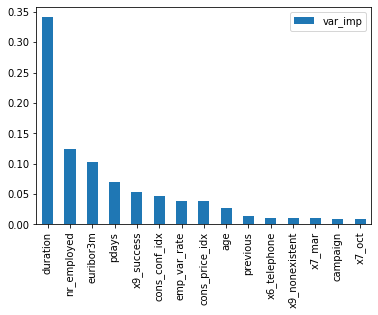

In [73]:
feature_imp_df[:15].plot(kind='bar')

In [74]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

# Using the function to calculate accuracy, precision and recall.
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

0.9201466446537827
0.9147851420247632
Test Precision:  0.8
Test Recall:  0.3203463203463203
Test Accuracy:  0.9147851420247632


## _Insights_

* Excel Sheet Analysis


* Positive : Yes to Campaign ; Negative : No to Campaign


* Recall Importance : False neg

# Interesting links:

https://scikit-learn.org/stable/

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html